In [1]:
from __future__ import print_function, division
import badlands 
from badlands.model import Model as badlandsModel
import numpy as np
from scipy.spatial import cKDTree
from numpy import genfromtxt
import matplotlib.pyplot as plt
import math, csv
import pandas as pd

# Converting Data to a regular grid

In [2]:
def interpolateArray(coords=None, z=None, dz=None):
    """
    Interpolate the irregular spaced dataset from badlands on a regular grid.
    """
    x, y = np.hsplit(coords, 2)
    dx = (x[1]-x[0])[0]

    nx = int(((x.max() - x.min())/dx+1) - 2)
    ny = int(((y.max() - y.min())/dx+1) - 2)
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)

    xi, yi = np.meshgrid(xi, yi)
    xyi = np.dstack([xi.flatten(), yi.flatten()])[0]
    XY = np.column_stack((x,y))

    tree = cKDTree(XY)
    distances, indices = tree.query(xyi, k=3)
    if len(z[indices].shape) == 3:
        z_vals = z[indices][:,:,0]
        dz_vals = dz[indices][:,:,0]
    else:
        z_vals = z[indices]
        dz_vals = dz[indices]

    zi = np.average(z_vals,weights=(1./distances), axis=1)
    dzi = np.average(dz_vals,weights=(1./distances), axis=1)
    onIDs = np.where(distances[:,0] == 0)[0]
    if len(onIDs) > 0:
        zi[onIDs] = z[indices[onIDs,0]]
        dzi[onIDs] = dz[indices[onIDs,0]]
    zreg = np.reshape(zi,(ny,nx))
    dzreg = np.reshape(dzi,(ny,nx))
    
    return zreg,dzreg

# Run Model to get dimensions of grid

In [3]:
model = badlandsModel()
model.load_xml('PreProc','../Examples/australia_gda94/AUSB004-pre.xml', muted = False)

In [4]:
model.run_to_time(-1.489E+08, muted = False)
elev, erdp = interpolateArray(model.FVmesh.node_coords[:, :2], model.elevation, model.cumdiff)

   - Writing outputs (0.25 seconds; tNow = -149000000.0)
   - Writing outputs (0.22 seconds; tNow = -148900000.0)


# Loading in present day ground truth data

In [5]:
present_day = pd.read_csv('master_50km_withPresentdayTopo_withPresentdaySedThick_withContinentPoints.csv',
                         names=["Longitude", "Latitude", "Easting", "Northing","Elevation", "Sediment_Thickness",
                                "Continent"])

present_day

,Longitude,Latitude,Easting,Northing,Elevation,Sediment_Thickness,Continent
0,85.378959,-46.488381,-3826242.634,-5.990130e+06,-3963.881868,NaN,0
1,85.953856,-46.648865,-3776242.634,-5.990130e+06,-3673.915612,NaN,0
2,86.530875,-46.807352,-3726242.634,-5.990130e+06,-3600.999292,NaN,0
3,87.110005,-46.963837,-3676242.634,-5.990130e+06,-3755.168239,NaN,0
4,87.691232,-47.118315,-3626242.634,-5.990130e+06,-4018.723714,NaN,0
...,...,...,...,...,...,...,...
20271,159.444398,9.064606,3323757.366,8.098705e+05,-5070.837847,NaN,0
20272,159.816561,9.141108,3373757.366,8.098705e+05,-5343.132809,NaN,0
20273,160.188265,9.218640,3423757.366,8.098705e+05,-5039.974759,NaN,0
20274,160.559505,9.297197,3473757.366,8.098705e+05,-5068.066189,NaN,0


### Initial Elevation

In [7]:
init_elev = np.loadtxt('../Examples/australia_gda94/AUSB004/Paleotopo/Paleotopo_BaseCase_50km_GDA94_prec2.csv')
print(init_elev.shape)
init_elev = init_elev[:,2]

(20276, 3)


### Elevation

In [8]:
present_day_elev = present_day[['Easting','Northing','Elevation']]
present_day_elev
pd_elev = present_day_elev.to_numpy()
print(pd_elev.shape)
pd_elev = pd_elev[:,2]

(20276, 3)


### Sediment Thickness / Erosion Deposition

In [9]:
present_day_erdp = present_day[['Easting','Northing','Sediment_Thickness']]
present_day_erdp
pd_erdp = present_day_erdp.to_numpy()
print(pd_erdp.shape)
pd_erdp = pd_erdp[:,2]

(20276, 3)


In [10]:
init_elev = init_elev.reshape(elev.shape[0], elev.shape[1])
pd_elev = pd_elev.reshape(elev.shape[0], elev.shape[1])
pd_erdp = pd_erdp.reshape(erdp.shape[0], erdp.shape[1])


In [11]:
np.savetxt('../Examples/australia_gda94/data/initial_elev.txt', init_elev)
np.savetxt('../Examples/australia_gda94/data/final_elev.txt', pd_elev)
np.savetxt('../Examples/australia_gda94/data/final_erdp.txt', pd_erdp)

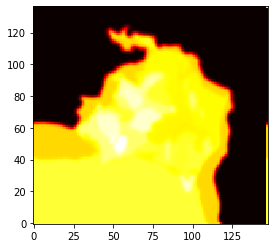

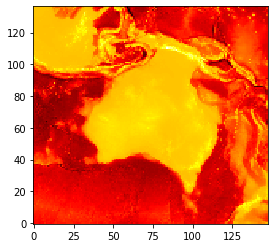

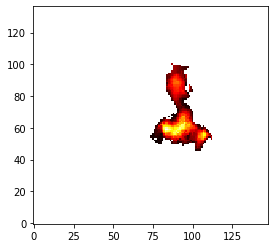

In [12]:
plt.imshow(init_elev, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()
plt.close()
plt.imshow(pd_elev, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()
plt.close()
plt.imshow(pd_erdp, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()
plt.close()

In [12]:
pd_elev_un_nan = np.nan_to_num(pd_elev)
pd_erdp_un_nan = np.nan_to_num(pd_erdp)

pd_elev_non_zero = pd_elev_un_nan.nonzero()
pd_erdp_non_zero = pd_erdp_un_nan.nonzero()

# print(pd_elev_non_zero)

In [13]:
erdp_coord = list(zip(pd_erdp_non_zero[0],pd_erdp_non_zero[1]))
print(erdp_coord[0])

erdp_coord = np.array(erdp_coord)
erdp_coord.shape
print(erdp_coord)
print(len(erdp_coord))
np.savetxt("../Examples/australia_gda94/data/erdp_coords.txt", np.array(erdp_coord, dtype = 'int'))

(46, 102)
[[ 46 102]
 [ 46 103]
 [ 46 104]
 ...
 [ 99  91]
 [ 99  92]
 [100  87]]
880


In [14]:
elev_coord = present_day[['Easting','Northing','Elevation','Continent']]

elev_coord.loc[elev_coord['Continent'] == 0, 'Elevation'] = np.nan

elev_coord = elev_coord.to_numpy()
elev_coord = elev_coord[:,2]
elev_coord = elev_coord.reshape(elev.shape[0], elev.shape[1])

elev_coord = np.nan_to_num(elev_coord)
elev_coord = elev_coord.nonzero()

elev_coords = list(zip(elev_coord[0], elev_coord[1]))
elev_coord = np.array(elev_coords)
print(elev_coord.shape, elev_coord, len(elev_coord))
np.savetxt("../Examples/australia_gda94/data/elev_coords.txt", np.array(elev_coord, dtype = 'int'))

(5597, 2) [[ 18  97]
 [ 18  98]
 [ 18  99]
 ...
 [119  81]
 [119  82]
 [119  83]] 5597


/home/danial/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
erd = {}
erd_list = []
for i,j in enumerate(erdp_coord):

    erd[tuple(j)] = pd_erdp_un_nan[j[0],j[1]]
    erd_list.append(pd_erdp_un_nan[j[0],j[1]]) 
    
print(len(erd))

880


In [16]:
erd_np = np.array(erd_list)
print(erd_np.shape)

(880,)


In [17]:
np.savetxt("../Examples/australia_gda94/data/final_erdp_pts.txt",np.array(erd_np),delimiter=' ',newline=' ')


In [18]:
elv = {}
elv_list = []
for i,j in enumerate(elev_coord):

    elv[tuple(j)] = pd_elev_un_nan[j[0],j[1]]
    elv_list.append(pd_elev_un_nan[j[0],j[1]])
    
print(len(elv))

5597


In [19]:
elv_np = np.array(elv_list)
print(elv_np.shape)

(5597,)


In [20]:
np.savetxt("../Examples/australia_gda94/data/final_elev_pts.txt", np.array(elv_np), delimiter=' ',newline=' ')

### Oceanic Marine Files

In [21]:
for i in range(151):
    m = np.loadtxt("04_Emergent_vs_Marine/marine_%s.dat" %(i))
    m = m.reshape(m.shape[0],1)
    m = m.reshape((elev.shape[0], elev.shape[1]))
    np.savetxt("../Examples/australia_gda94/data/ocean/marine_%s.txt" %(i),m)

Year :  0


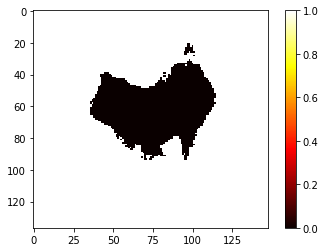

Year :  5


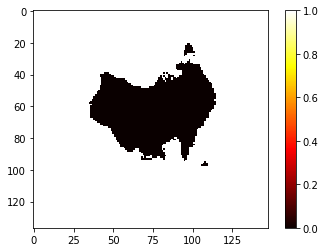

Year :  10


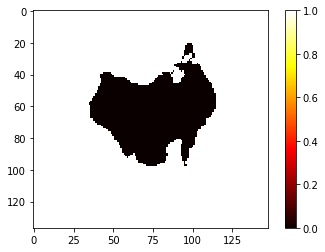

Year :  15


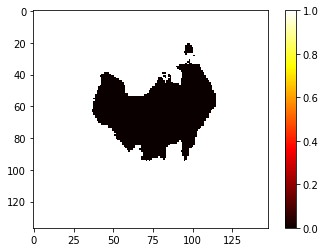

Year :  20


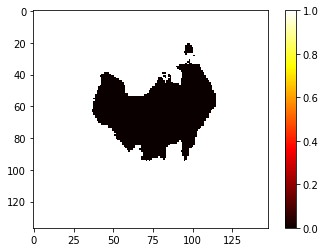

Year :  25


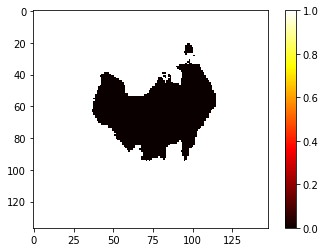

Year :  30


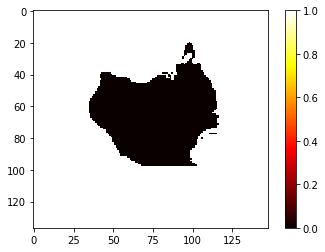

Year :  35


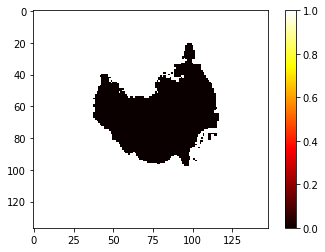

Year :  40


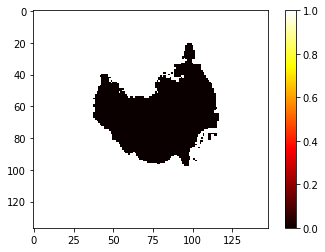

Year :  45


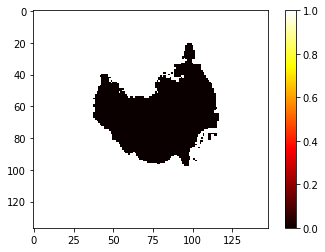

Year :  50


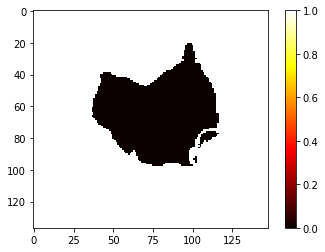

Year :  55


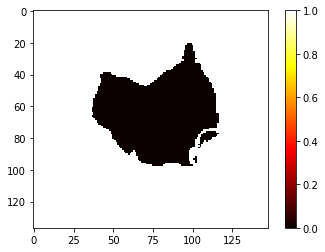

Year :  60


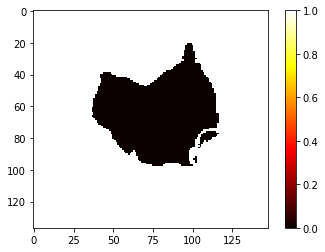

Year :  65


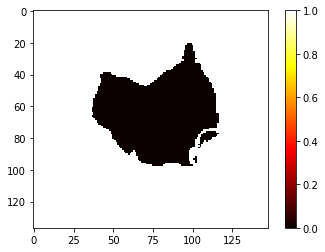

Year :  70


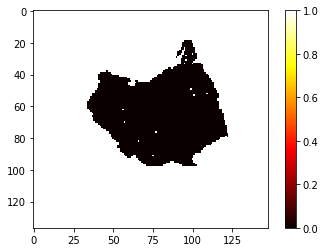

Year :  75


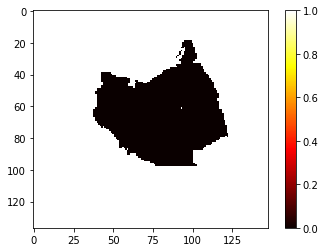

Year :  80


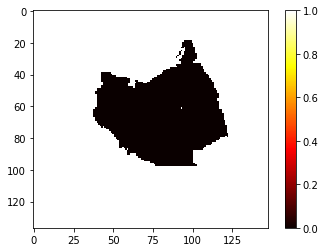

Year :  85


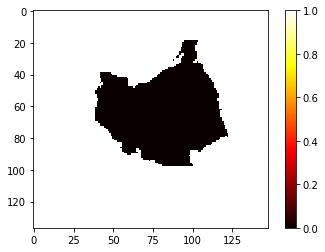

Year :  90


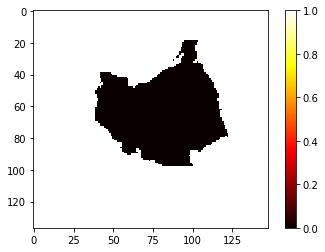

Year :  95


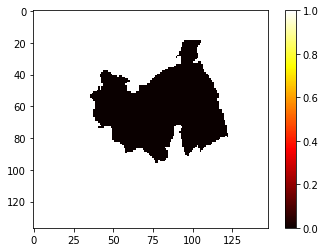

Year :  100


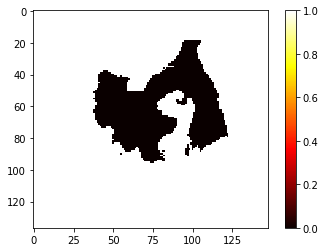

Year :  105


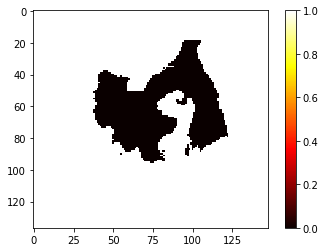

Year :  110


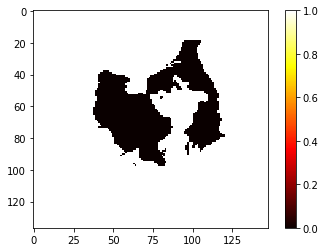

Year :  115


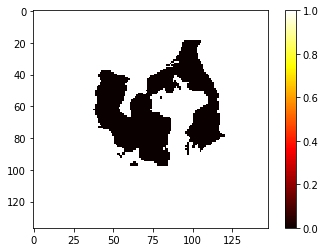

Year :  120


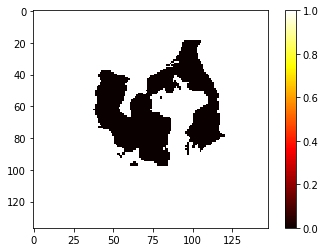

Year :  125


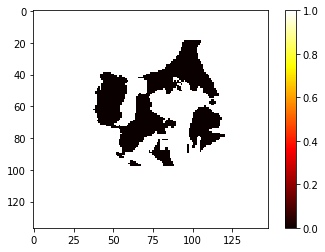

Year :  130


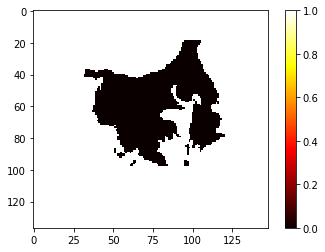

Year :  135


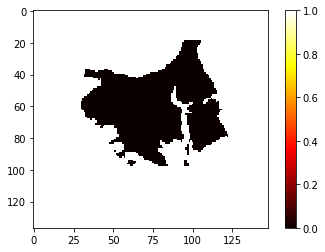

Year :  140


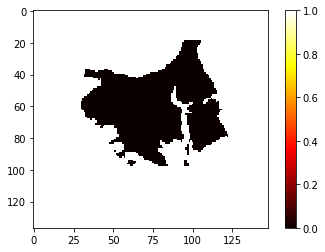

Year :  145


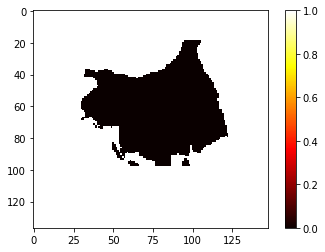

Year :  150


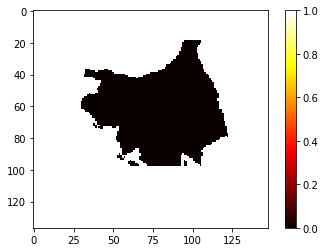

In [22]:
for i in range(0,155,5):
    ocean = np.loadtxt('../Examples/australia_gda94/data/ocean/marine_%s.txt'%(i))
    print ('Year : ', i)
    plt.imshow(ocean, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    plt.savefig('../Examples/australia_gda94/data/ocean/marine_%s.png'%(i))
    plt.close()